In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error

Importer des données

2023-06-24 01:59:10 - 2023-07-11 10:49:42
"09 July 2023:	Measurement error with regard to fine dust values due to sudden increase in air humidity"
Nous supprimons les données contenant des informations postérieures au 9 juillet

In [2]:

data=pd.read_csv("./laboratory.csv")

In [3]:
data.head()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
0,14.966,20.688,0.007,4.867,1.522,20.867,910.0,548.505,1876,38.461,...,968.0,24.841,0.014,11.550,44.833,-0.03,8.182,21.999,0.0,16.234
1,14.996,20.687,0.001,3.496,1.521,20.865,915.0,543.500,1887,38.462,...,942.0,24.845,0.002,11.520,44.784,-0.06,8.172,24.962,0.0,14.324
2,15.000,20.687,0.000,5.134,1.521,20.866,916.0,542.134,1858,38.463,...,938.0,24.834,0.000,11.506,44.768,-0.07,8.170,25.293,0.0,15.826
3,14.081,20.688,0.213,4.223,1.521,20.864,918.0,539.314,1856,38.462,...,936.0,24.834,0.618,11.438,44.766,-0.04,8.169,26.403,0.0,12.719
4,14.258,20.687,0.152,8.701,1.522,20.867,915.0,543.551,1862,38.462,...,935.0,24.838,0.543,11.393,44.768,0.00,8.170,25.934,0.0,26.107


In [4]:
data.tail()

,TypPS,oxygen,pm10,cnt0_5,co,temperature,performance,co2,measuretime,so2,...,health,temperature_o2,cnt2_5,o3,humidity,dHdt,humidity_abs,sound,pm2_5,cnt0_3
51181,2.257,20.906,4.770,227.998,1.530,24.533,798.0,517.499,2046,176.872,...,820.0,28.700,0.958,28.679,39.472,-0.18,8.888,66.425,4.150,710.289
51182,1.920,20.906,4.169,229.625,1.529,24.546,782.0,524.201,2088,177.372,...,844.0,28.721,0.405,28.932,39.171,-0.30,8.826,65.066,3.800,725.006
51183,1.688,20.907,5.038,228.146,1.529,24.572,772.0,516.942,1827,173.799,...,803.0,28.757,0.529,29.264,38.641,-0.56,8.720,62.035,4.670,721.098
51184,1.515,20.905,5.092,246.341,1.530,24.590,761.0,517.797,1828,167.632,...,790.0,28.797,0.394,29.504,38.329,-0.63,8.658,65.898,4.789,780.604
51185,1.225,20.907,4.216,229.139,1.532,24.614,758.0,512.732,1999,162.133,...,822.0,28.815,0.840,29.658,38.106,-0.60,8.619,64.354,4.177,726.724


Les données sont de 12445x31 et nous devons filtrer les valeurs nulles et les paramètres de mesure qui ne nous concernent pas.

In [5]:
print(data)

        TypPS  oxygen   pm10   cnt0_5     co  temperature  performance  \
0      14.966  20.688  0.007    4.867  1.522       20.867        910.0   
1      14.996  20.687  0.001    3.496  1.521       20.865        915.0   
2      15.000  20.687  0.000    5.134  1.521       20.866        916.0   
3      14.081  20.688  0.213    4.223  1.521       20.864        918.0   
4      14.258  20.687  0.152    8.701  1.522       20.867        915.0   
...       ...     ...    ...      ...    ...          ...          ...   
51181   2.257  20.906  4.770  227.998  1.530       24.533        798.0   
51182   1.920  20.906  4.169  229.625  1.529       24.546        782.0   
51183   1.688  20.907  5.038  228.146  1.529       24.572        772.0   
51184   1.515  20.905  5.092  246.341  1.530       24.590        761.0   
51185   1.225  20.907  4.216  229.139  1.532       24.614        758.0   

           co2  measuretime      so2  ...  health  temperature_o2 cnt2_5  \
0      548.505         1876   38.46

In [6]:
nan_rows_count = data.isna().any(axis=1).sum()

print(f"\n Le nombre de lignes contenant des valeurs NaN est de: {nan_rows_count}")


 Le nombre de lignes contenant des valeurs NaN est de: 0


**Nettoyage des données**

Supprimer les lignes Nan et les colonnes de caractéristiques inintéressantes

In [7]:
data.drop(['TypPS', 'cnt0_5','cnt1','performance','measuretime','temperature_o2','sound_max','cnt5','cnt10','dCO2dt','health','cnt2_5','humidity_abs','dHdt','cnt0_3'], axis=1, inplace=True)
data.dropna(inplace=True)
data['timestamp'] = pd.to_datetime(data['timestamp'])

Nous supprimons les données contenant des informations postérieures au 9 juillet

"température", "pression", "humidité" à la fin des colonnes de données

In [8]:
dates_to_remove = ['2023-07-09','2023-07-10','2023-07-11']
dates_to_remove = pd.to_datetime(dates_to_remove)
data = data[~data['timestamp'].dt.normalize().isin(dates_to_remove)]
columns = list(data.columns)
columns.remove('temperature')
columns.remove('pressure')
columns.remove('humidity')
columns.extend(['temperature', 'pressure', 'humidity'])

data = data[columns]

Modifier le nom de timestamp et le convertir en index

In [9]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

timestamp_col = data.pop('timestamp')
data.insert(0, 'date', timestamp_col)

data = data.set_index(['date'])

print(data.tail(10))

                     oxygen   pm10     co      co2      so2     no2    pm1  \
date                                                                         
2023-06-06 16:42:02  20.906  4.076  1.531  526.735  169.758  26.577  3.533   
2023-06-06 16:44:04  20.905  3.634  1.532  522.241  170.855  27.693  2.479   
2023-06-06 16:46:06  20.908  3.014  1.531  526.957  170.967  28.437  2.568   
2023-06-06 16:48:06  20.911  4.198  1.531  525.579  171.101  27.761  2.375   
2023-06-06 16:50:07  20.907  4.702  1.530  519.971  174.024  27.500  3.570   
2023-06-06 16:52:03  20.906  4.770  1.530  517.499  176.872  27.301  3.683   
2023-06-06 16:53:57  20.906  4.169  1.529  524.201  177.372  26.331  3.232   
2023-06-06 16:56:11  20.907  5.038  1.529  516.942  173.799  24.875  4.050   
2023-06-06 16:58:12  20.905  5.092  1.530  517.797  167.632  23.244  4.315   
2023-06-06 17:00:10  20.907  4.216  1.532  512.732  162.133  22.675  3.676   

                     dewpt     tvoc      o3   sound  pm2_5  tem

Présenter l'évolution de la valeur de la mesure qui nous intéresse au cours de l'échantillon

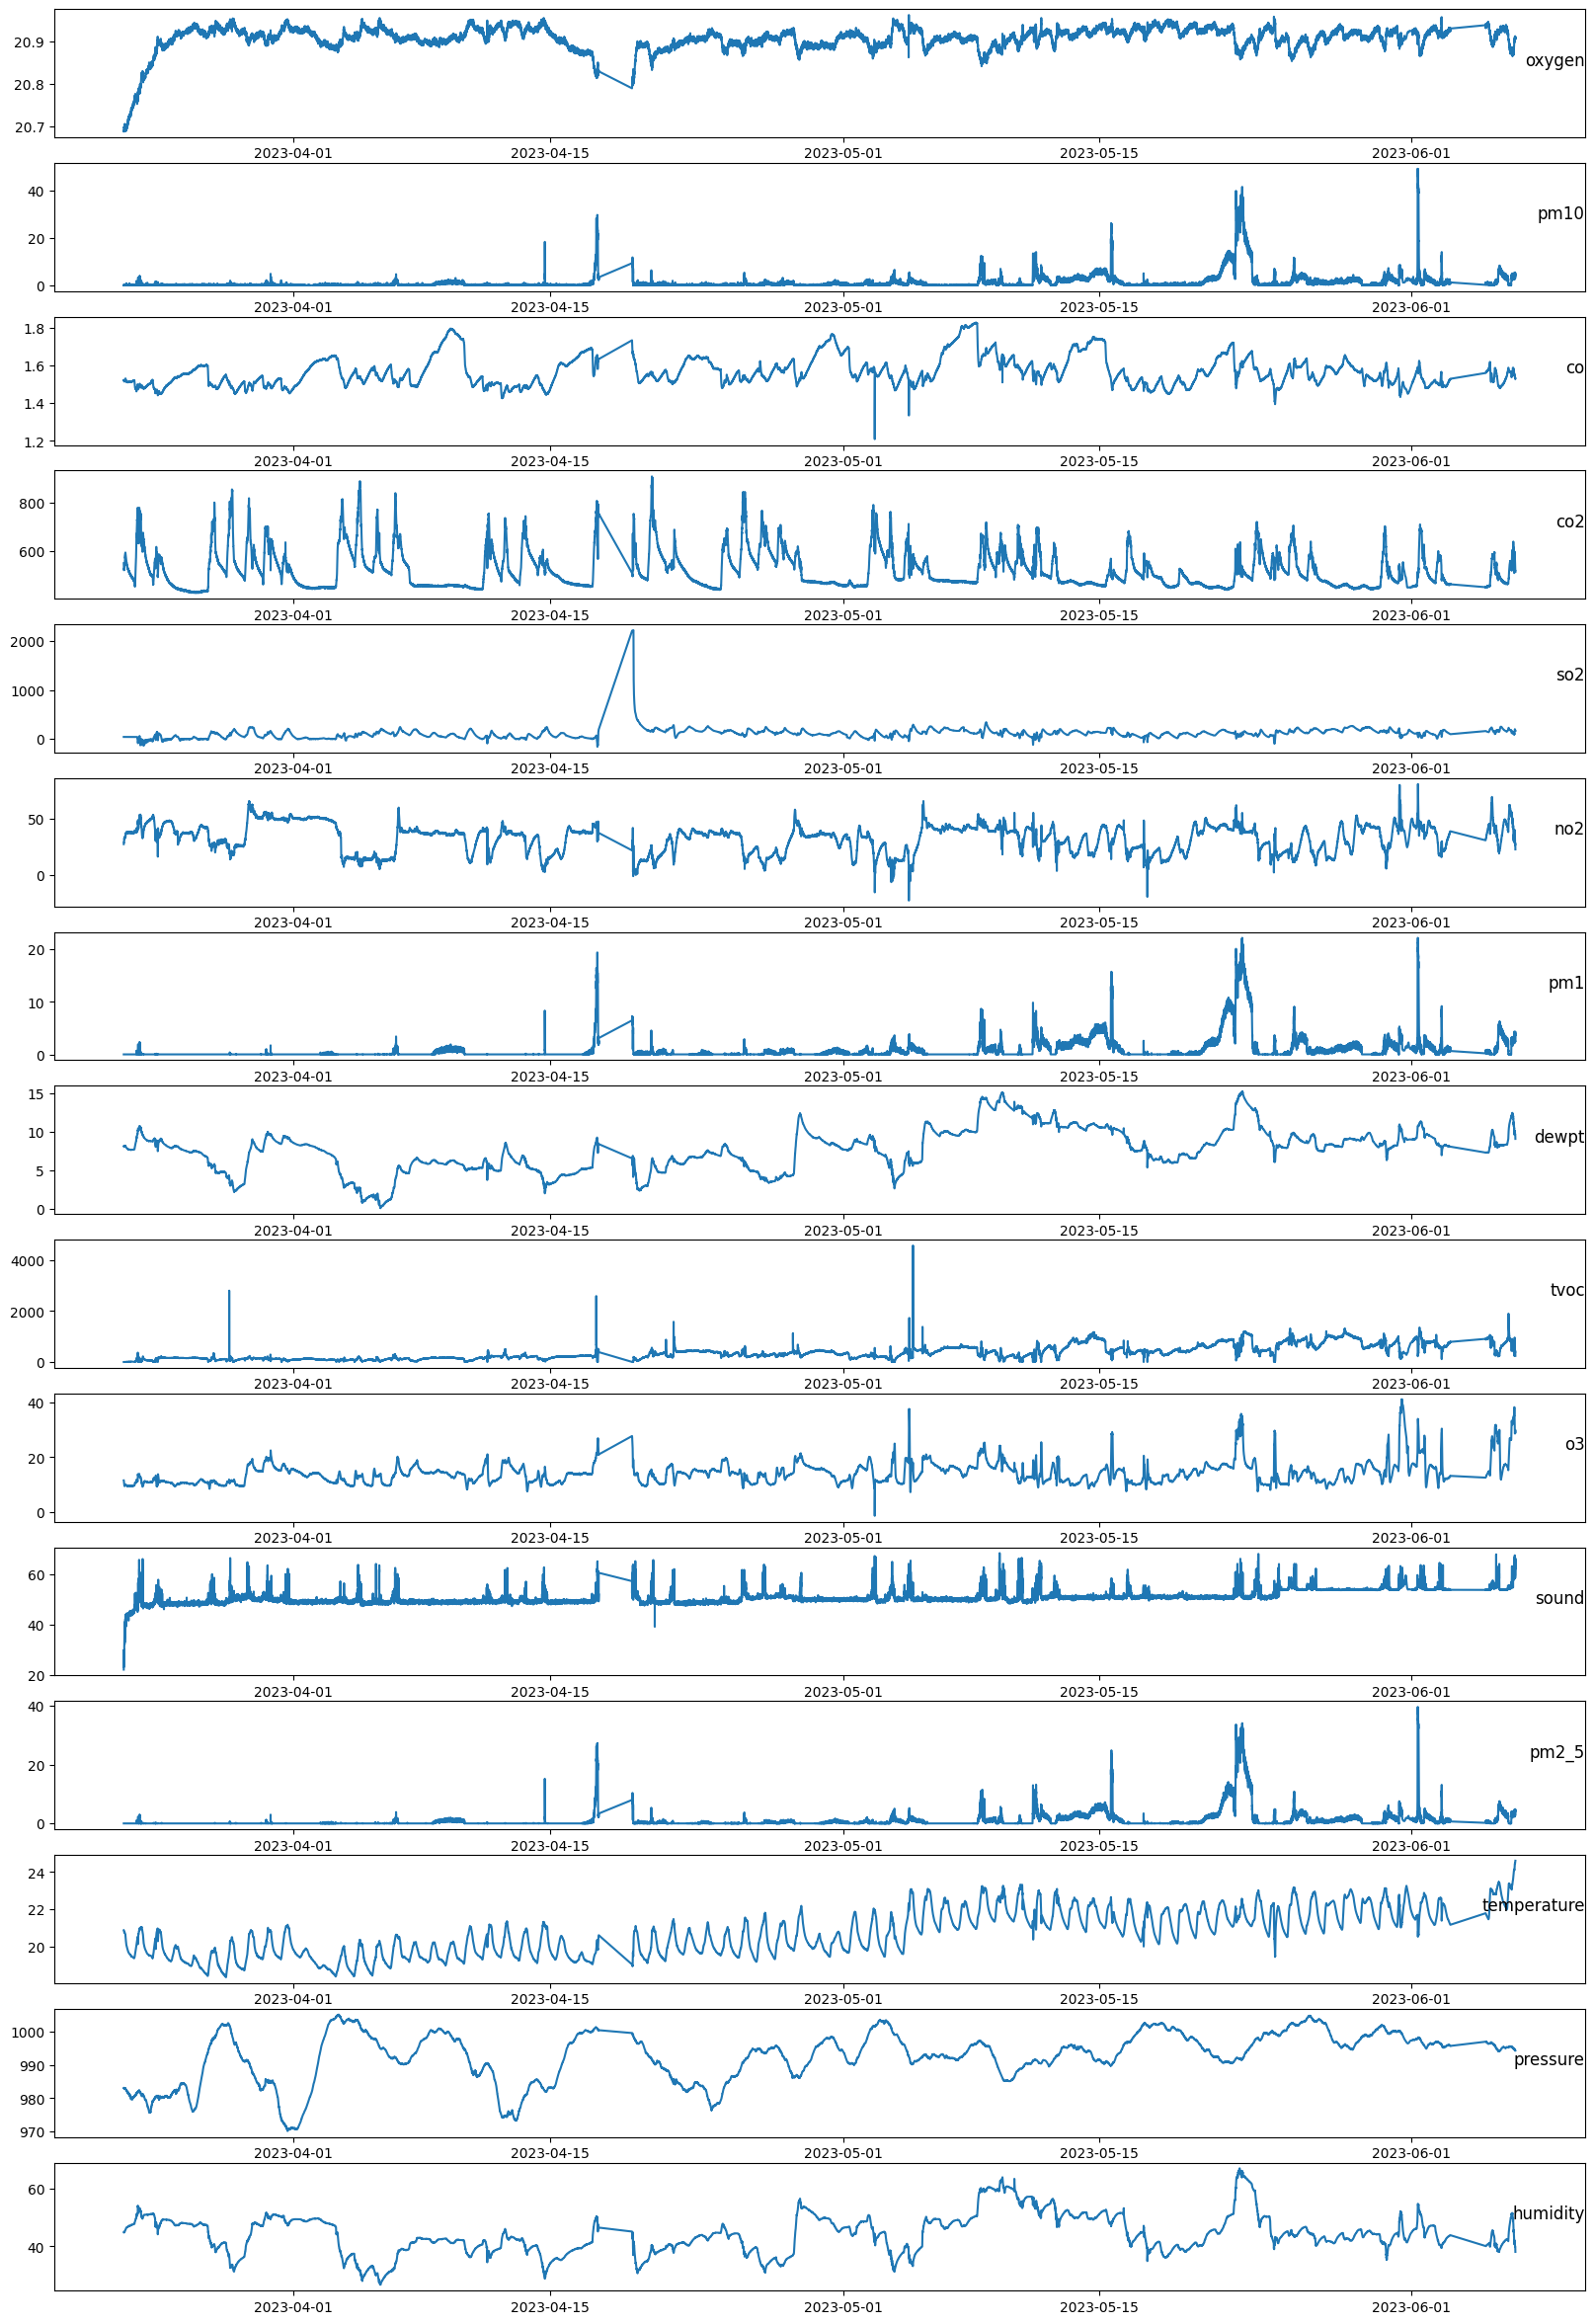

In [10]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13, 14]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

Voir la relation entre chaque paramètre et l'IQA

In [11]:
# data['IAQ'] = (data['pm1']<=10) & (data['pm2_5']<=25) & (data['pm10']<=50) & (data['co2']<800) & (data['tvoc']<300) & (data['o3']<18)
# data['IAQ'] = data['IAQ'].astype(object).replace({False: 0, True: 1})
# data.insert(0, 'IAQ', data.pop('IAQ'))

PM2.5 (Particulate Matter 2.5-micrometer)

PM2.5 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [12]:
## PM2.5 Sub-Index calculation
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

data["PM2.5_SubIndex"] = data["pm2_5"].apply(lambda x: get_PM25_subindex(x))

PM10 (Particulate Matter 10-micrometer)

PM10 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [13]:
## PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

data["PM10_SubIndex"] = data["pm10"].apply(lambda x: get_PM10_subindex(x))

SO2 (Sulphur Dioxide)

SO2 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [14]:
## SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

data["SO2_SubIndex"] = data["so2"].apply(lambda x: get_SO2_subindex(x))

NOx (Any Nitric x-oxide)

NOx is measured in ppb (parts per billion). The predefined groups are defined in the function below:

In [15]:
## NOx Sub-Index calculation
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

data["NO2_SubIndex"] = data["no2"].apply(lambda x: get_NO2_subindex(x))

CO (Carbon Monoxide)

CO is measured in mg / m3 (milligrams per cubic meter of air). The predefined groups are defined in the function below:

In [16]:
## CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

data["CO_SubIndex"] = data["co"].apply(lambda x: get_CO_subindex(x))

O3 (Ozone or Trioxygen)

O3 is measured in ug / m3 (micrograms per cubic meter of air). The predefined groups are defined in the function below:

In [17]:
## O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

data["O3_SubIndex"] = data["o3"].apply(lambda x: get_O3_subindex(x))

AQI

The final AQI is the maximum Sub-Index among the available sub-indices with the condition that at least one of PM2.5 and PM10 should be available and at least three out of the seven should be available.

There is no theoretical upper value of AQI but its rare to find values over 1000.

In [18]:
## AQI bucketing
def get_AQI_bucket(x):
    if x <= 50:
        return "Good"
    elif x <= 100:
        return "Satisfactory"
    elif x <= 200:
        return "Moderate"
    elif x <= 300:
        return "Poor"
    elif x <= 400:
        return "Very Poor"
    elif x > 400:
        return "Severe"
    else:
        return np.NaN

data["Checks"] = (data["PM2.5_SubIndex"] > 0).astype(int) + \
                (data["PM10_SubIndex"] > 0).astype(int) + \
                (data["SO2_SubIndex"] > 0).astype(int) + \
                (data["NO2_SubIndex"] > 0).astype(int) + \
                (data["CO_SubIndex"] > 0).astype(int) + \
                (data["O3_SubIndex"] > 0).astype(int)

data["AQI_calculated"] = round(data[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NO2_SubIndex",
                                 "CO_SubIndex", "O3_SubIndex"]].max(axis = 1))
data.loc[data["PM2.5_SubIndex"] + data["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN
data.loc[data.Checks < 3, "AQI_calculated"] = np.NaN

data["AQI_bucket_calculated"] = data["AQI_calculated"].apply(lambda x: get_AQI_bucket(x))
data.insert(0, 'AQI_calculated', data.pop('AQI_calculated'))
data[~data.AQI_calculated.isna()].head(13)

,AQI_calculated,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,...,pressure,humidity,PM2.5_SubIndex,PM10_SubIndex,SO2_SubIndex,NO2_SubIndex,CO_SubIndex,O3_SubIndex,Checks,AQI_bucket_calculated
date,,,,,,,,,,,,,,,,,,,,,
2023-03-22 17:42:49,76.0,20.688,0.007,1.522,548.505,38.461,27.406,0.0,8.114,0.0,...,983.066,44.833,0.0,0.007,48.07625,34.25750,76.10,11.550,5,Satisfactory
2023-03-22 17:44:48,76.0,20.687,0.001,1.521,543.500,38.462,27.771,0.0,8.095,0.0,...,983.102,44.784,0.0,0.001,48.07750,34.71375,76.05,11.520,5,Satisfactory
2023-03-22 17:48:48,76.0,20.688,0.213,1.521,539.314,38.462,28.165,0.0,8.088,0.0,...,983.112,44.766,0.0,0.213,48.07750,35.20625,76.05,11.438,5,Satisfactory
2023-03-22 17:50:49,76.0,20.687,0.152,1.522,543.551,38.462,28.421,0.0,8.091,0.0,...,983.097,44.768,0.0,0.152,48.07750,35.52625,76.10,11.393,5,Satisfactory
2023-03-22 17:52:50,76.0,20.691,0.104,1.522,541.996,38.461,28.739,0.0,8.086,0.0,...,983.085,44.766,0.0,0.104,48.07625,35.92375,76.10,11.302,5,Satisfactory
2023-03-22 17:54:49,76.0,20.691,0.012,1.523,537.025,38.458,28.765,0.0,8.077,0.0,...,983.066,44.765,0.0,0.012,48.07250,35.95625,76.15,11.199,5,Satisfactory
2023-03-22 17:56:49,76.0,20.688,0.001,1.521,532.191,38.455,28.914,0.0,8.066,0.0,...,983.032,44.765,0.0,0.001,48.06875,36.14250,76.05,11.046,5,Satisfactory
2023-03-22 18:14:52,76.0,20.695,0.178,1.518,520.130,38.444,31.596,0.0,8.041,0.0,...,983.084,44.881,0.0,0.178,48.05500,39.49500,75.90,10.256,5,Satisfactory
2023-03-22 18:16:54,76.0,20.695,0.020,1.518,522.049,38.445,32.004,0.0,8.050,0.0,...,983.083,44.894,0.0,0.020,48.05625,40.00500,75.90,10.192,5,Satisfactory


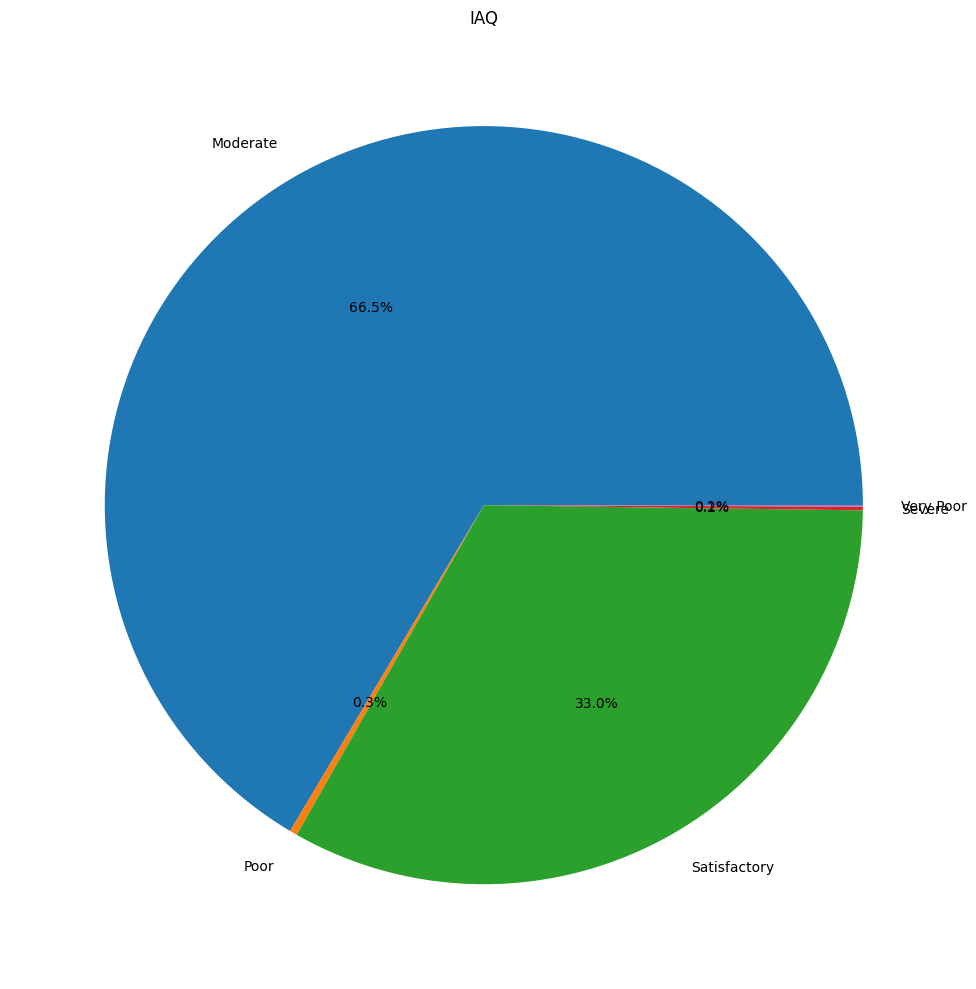

In [19]:
filtered_data = data['AQI_bucket_calculated'].dropna()
unique_values, counts = np.unique(filtered_data.values, return_counts=True)
proportions = counts / len(filtered_data)
fig, ax = plt.subplots(figsize=(10, 10))
ax.pie(proportions, labels=unique_values, autopct='%.1f%%')
ax.set_title('IAQ')
plt.tight_layout()
plt.show()

In [20]:
data.drop(['PM2.5_SubIndex', 'PM10_SubIndex', 'SO2_SubIndex', 'NO2_SubIndex', 'CO_SubIndex', 'O3_SubIndex','Checks','AQI_bucket_calculated'], axis=1, inplace=True)
data

,AQI_calculated,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,o3,sound,pm2_5,temperature,pressure,humidity
date,,,,,,,,,,,,,,,,
2023-03-22 17:42:49,76.0,20.688,0.007,1.522,548.505,38.461,27.406,0.000,8.114,0.000,11.550,21.999,0.000,20.867,983.066,44.833
2023-03-22 17:44:48,76.0,20.687,0.001,1.521,543.500,38.462,27.771,0.000,8.095,0.000,11.520,24.962,0.000,20.865,983.102,44.784
2023-03-22 17:46:50,NaN,20.687,0.000,1.521,542.134,38.463,27.913,0.000,8.090,0.000,11.506,25.293,0.000,20.866,983.112,44.768
2023-03-22 17:48:48,76.0,20.688,0.213,1.521,539.314,38.462,28.165,0.000,8.088,0.000,11.438,26.403,0.000,20.864,983.112,44.766
2023-03-22 17:50:49,76.0,20.687,0.152,1.522,543.551,38.462,28.421,0.000,8.091,0.000,11.393,25.934,0.000,20.867,983.097,44.768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-06 16:52:03,132.0,20.906,4.770,1.530,517.499,176.872,27.301,3.683,9.514,314.435,28.679,66.425,4.150,24.533,994.396,39.472
2023-06-06 16:53:57,132.0,20.906,4.169,1.529,524.201,177.372,26.331,3.232,9.412,285.701,28.932,65.066,3.800,24.546,994.381,39.171
2023-06-06 16:56:11,131.0,20.907,5.038,1.529,516.942,173.799,24.875,4.050,9.232,244.609,29.264,62.035,4.670,24.572,994.372,38.641


In [21]:
d = data.corr()
display(d)

,AQI_calculated,oxygen,pm10,co,co2,so2,no2,pm1,dewpt,tvoc,o3,sound,pm2_5,temperature,pressure,humidity
AQI_calculated,1.000000,-0.044688,0.024655,0.077841,0.005155,0.935478,-0.187751,0.055742,0.020459,0.250106,0.041724,0.232799,0.027128,0.336115,0.051736,-0.126144
oxygen,-0.044688,1.000000,-0.050140,-0.100131,-0.273459,-0.043080,-0.154889,-0.030356,-0.184202,0.126543,-0.078947,0.144637,-0.048067,0.036985,0.050009,-0.243057
pm10,0.024655,-0.050140,1.000000,0.131971,-0.022821,0.049064,0.114912,0.977984,0.363477,0.296979,0.447201,0.253859,0.996534,0.248380,0.089377,0.357208
co,0.077841,-0.100131,0.131971,1.000000,-0.320499,0.090371,0.180517,0.183297,0.268236,0.291823,0.036886,-0.088671,0.147924,0.034627,0.196291,0.311871
co2,0.005155,-0.273459,-0.022821,-0.320499,1.000000,0.055002,-0.283616,-0.051290,-0.120792,-0.185927,0.035838,0.208196,-0.034323,0.093604,0.040130,-0.169749
so2,0.935478,-0.043080,0.049064,0.090371,0.055002,1.000000,-0.179331,0.070886,0.038410,0.231919,0.115729,0.255741,0.048929,0.329962,0.131406,-0.107850
no2,-0.187751,-0.154889,0.114912,0.180517,-0.283616,-0.179331,1.000000,0.114915,0.473489,0.046333,0.460129,-0.104576,0.120729,-0.087990,-0.336170,0.602200
pm1,0.055742,-0.030356,0.977984,0.183297,-0.051290,0.070886,0.114915,1.000000,0.391721,0.362185,0.425535,0.255355,0.986235,0.280414,0.097484,0.374386
dewpt,0.020459,-0.184202,0.363477,0.268236,-0.120792,0.038410,0.473489,0.391721,1.000000,0.443504,0.407564,0.285253,0.369188,0.626675,-0.088788,0.923883
tvoc,0.250106,0.126543,0.296979,0.291823,-0.185927,0.231919,0.046333,0.362185,0.443504,1.000000,0.121563,0.462045,0.305536,0.607693,0.295901,0.235912


Une carte thermique（est un moyen de montrer la corrélation entre plusieurs variables à la fois.）

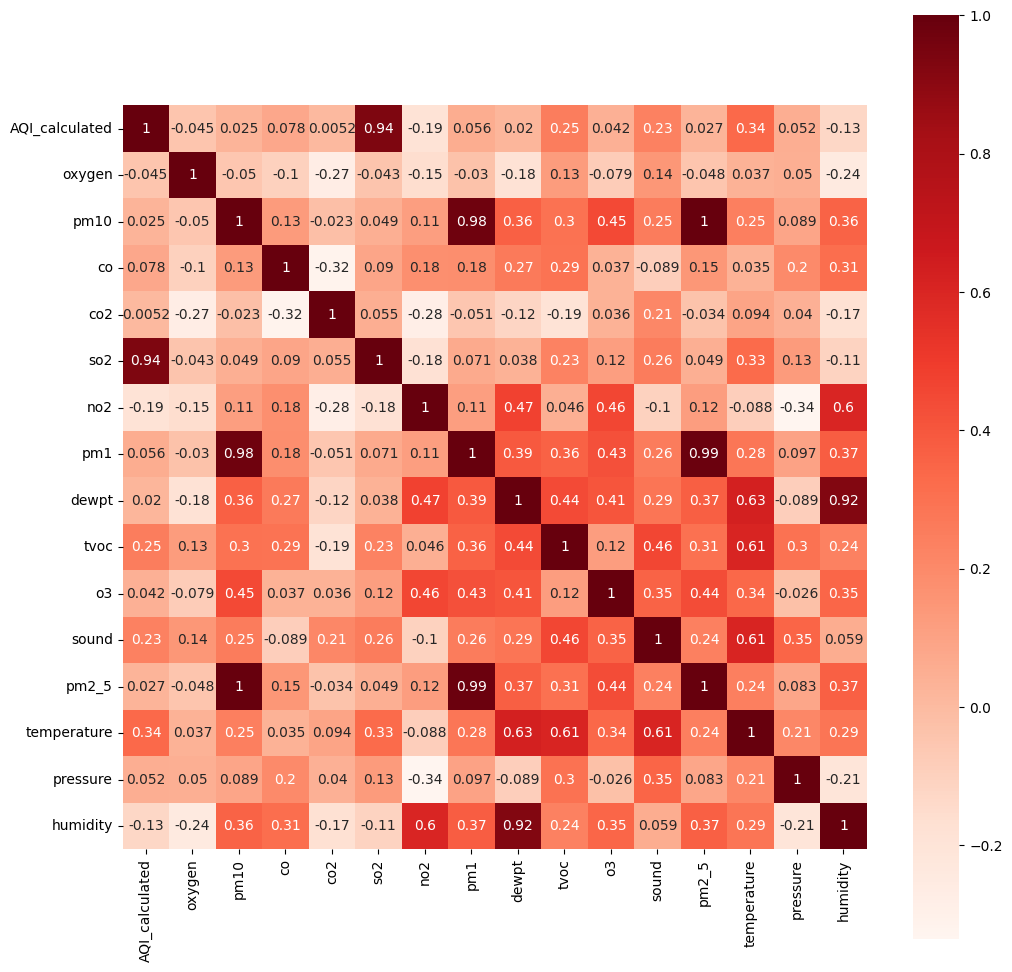

In [22]:
import seaborn as sns
plt.subplots(figsize = (12,12))
sns.heatmap(d,annot = True,vmax = 1,square = True,cmap = "Reds")
plt.show()

L'observation de la carte thermique permet de tirer les conclusions suivantes
1. **IAQ**(PM2.5, PM10, SO2, NO2, CO, O3)SO2>CO>O3>PM2.5>PM10>NO2(-), Il est facile de voir que dans l'ensemble des données, le so2 affecte sérieusement la qualité de l'air.
2. **L'oxygène** est inversement corrélé avec CO2>L'humidité
3. Il existe une forte corrélation entre les PM10 et les PM1 et PM2.5.
4. CO：humidité>tvoc>dewpt     corrélation négative(CO2)
5. CO2: sound       :CO>NO2>O2
6. SO2: T>sound>TVOC
7. NO2: humidité>dewpt>O3   :pression
8. PM1: PM>humidité>dewpt>O3>TVOC
9. dewpt a une corrélation forte avec l'humidité   humidité>T>NO2>TVOC>O3>PM
10. TVOC: T>NO2>PM>sound>dewpt
11. O3: NO2>PM>dewpt
12. sound: T>TVOC>O3 

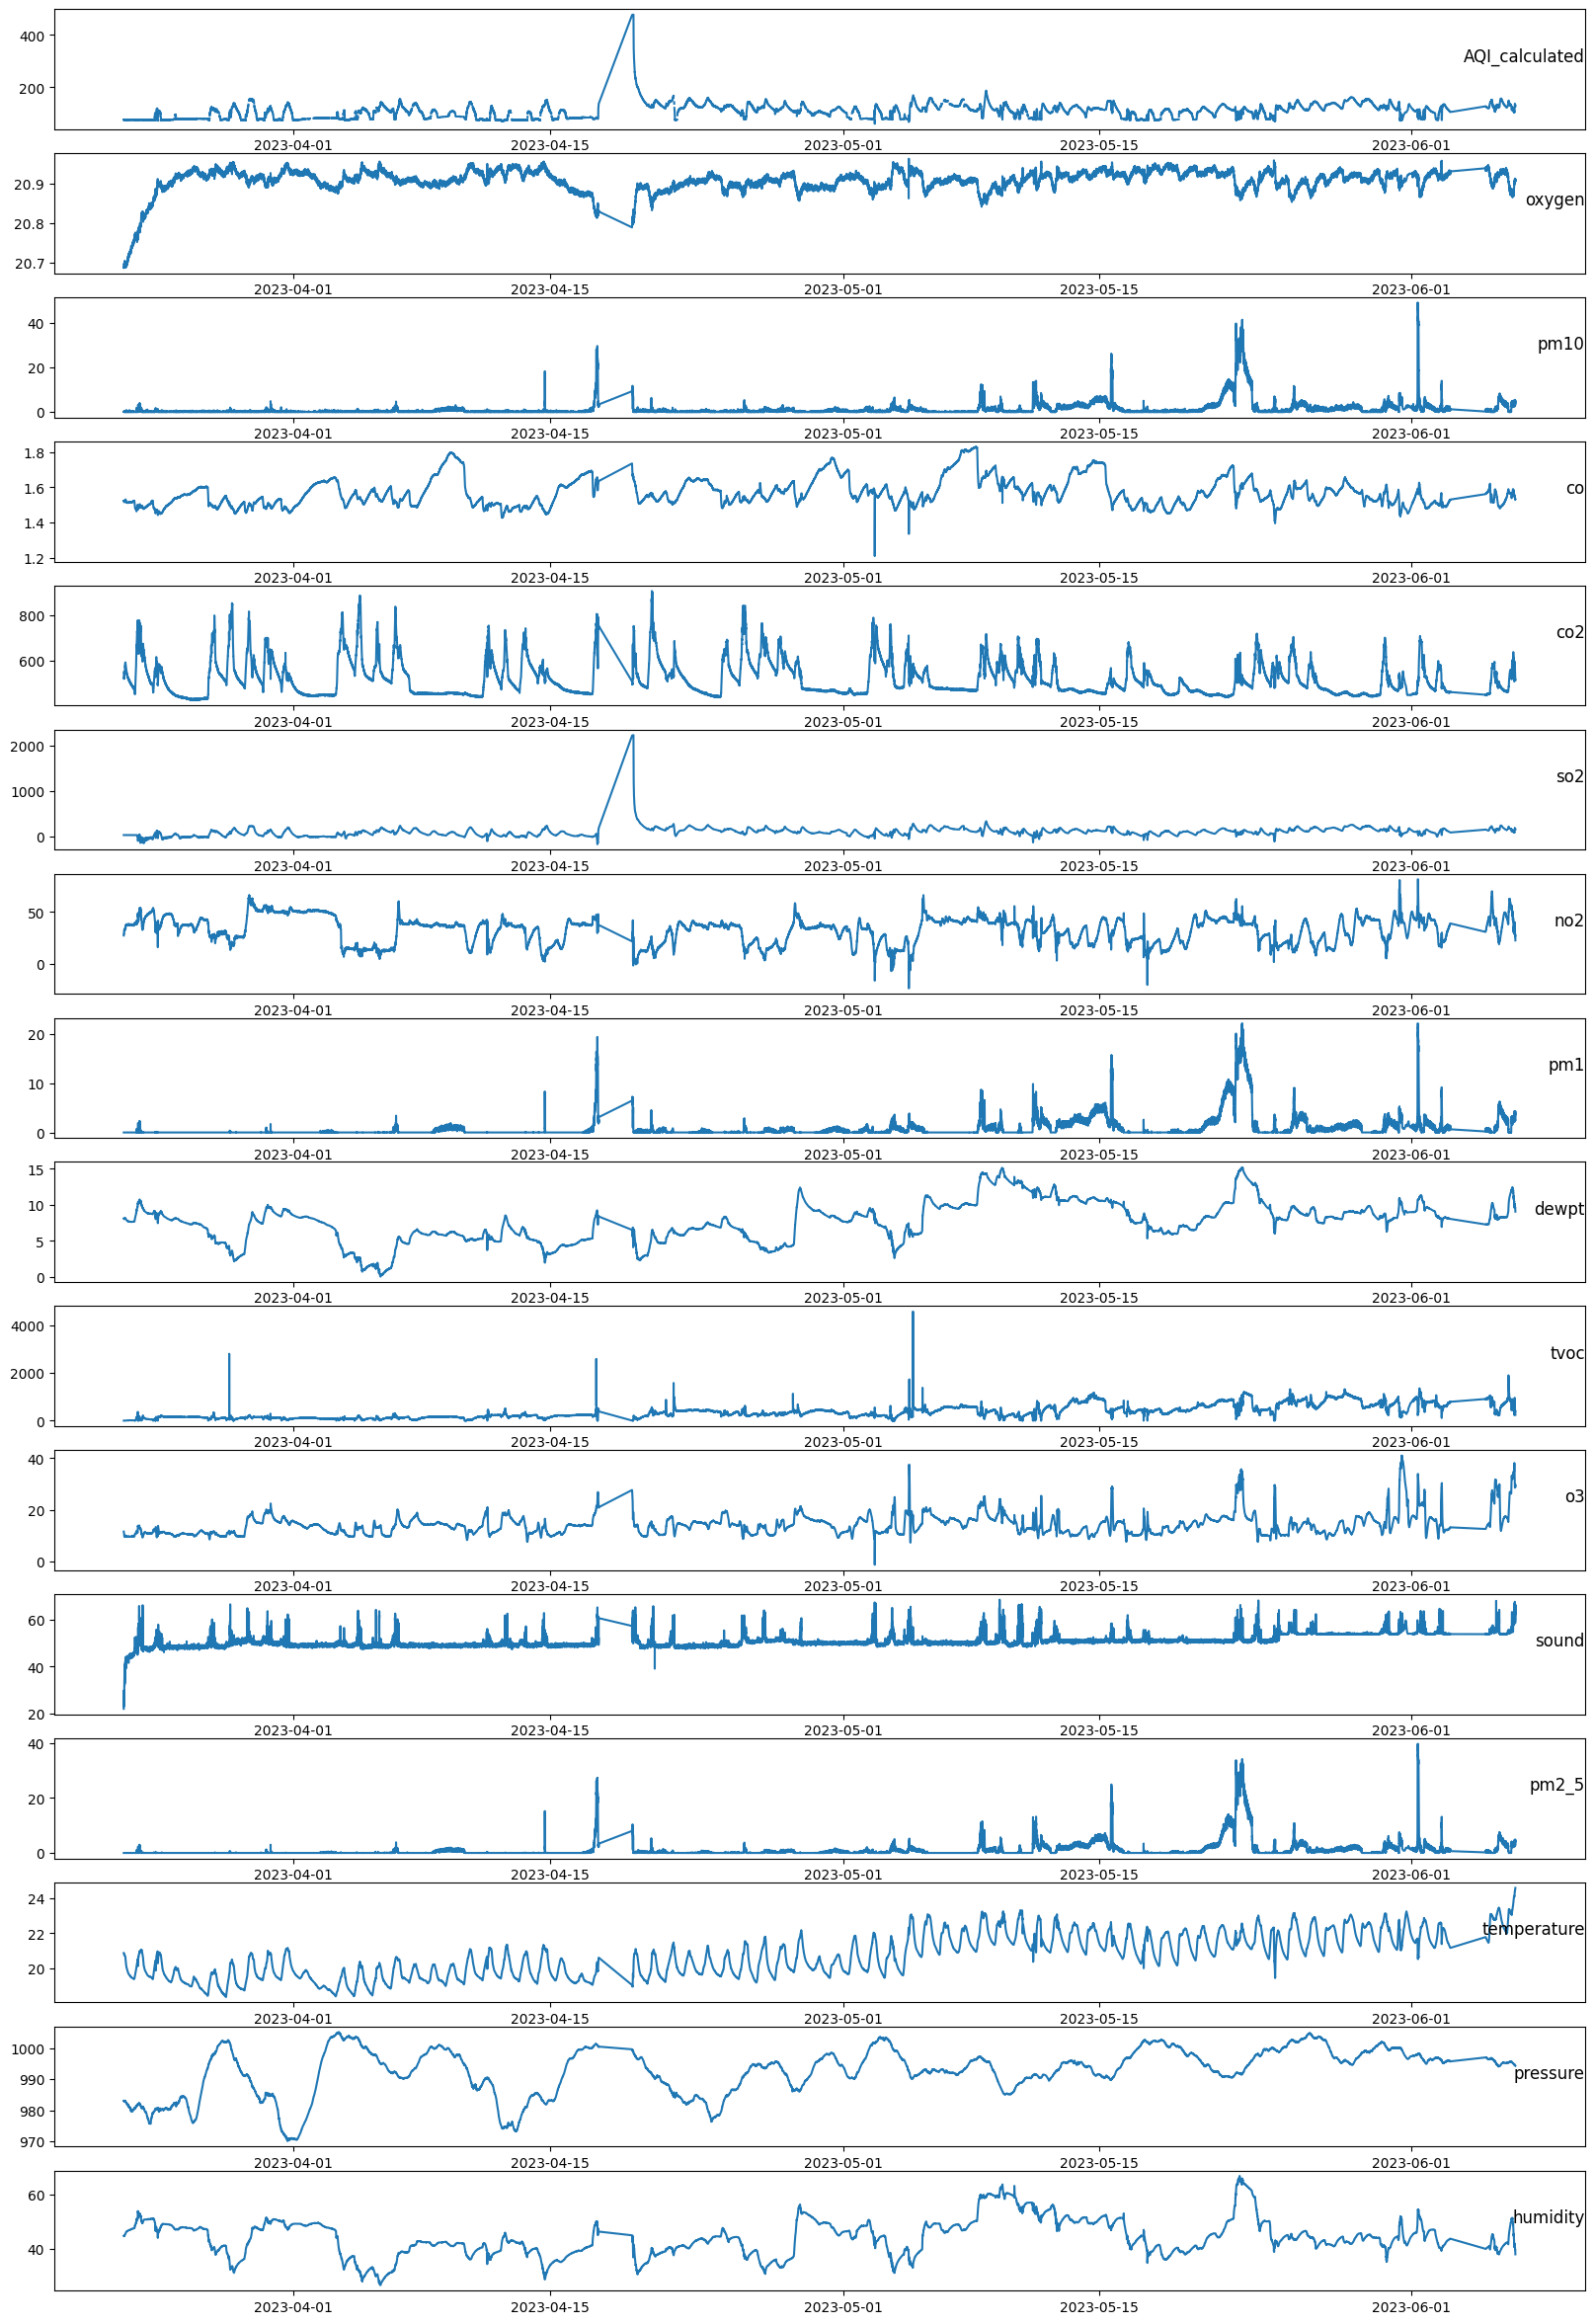

In [23]:
values = data.values
dates = data.index
groups = [0, 1, 2, 3, 4, 5, 6, 7 ,8 ,9 ,10 ,11 ,12, 13, 14, 15]
i = 1

plt.figure(figsize=(20,30))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(dates,values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()#date

Les conclusions sont généralement correctes, certaines sont moins évidentes

Supprimer les IAQ pour éviter que diverses opérations n'affectent les données par la suite.

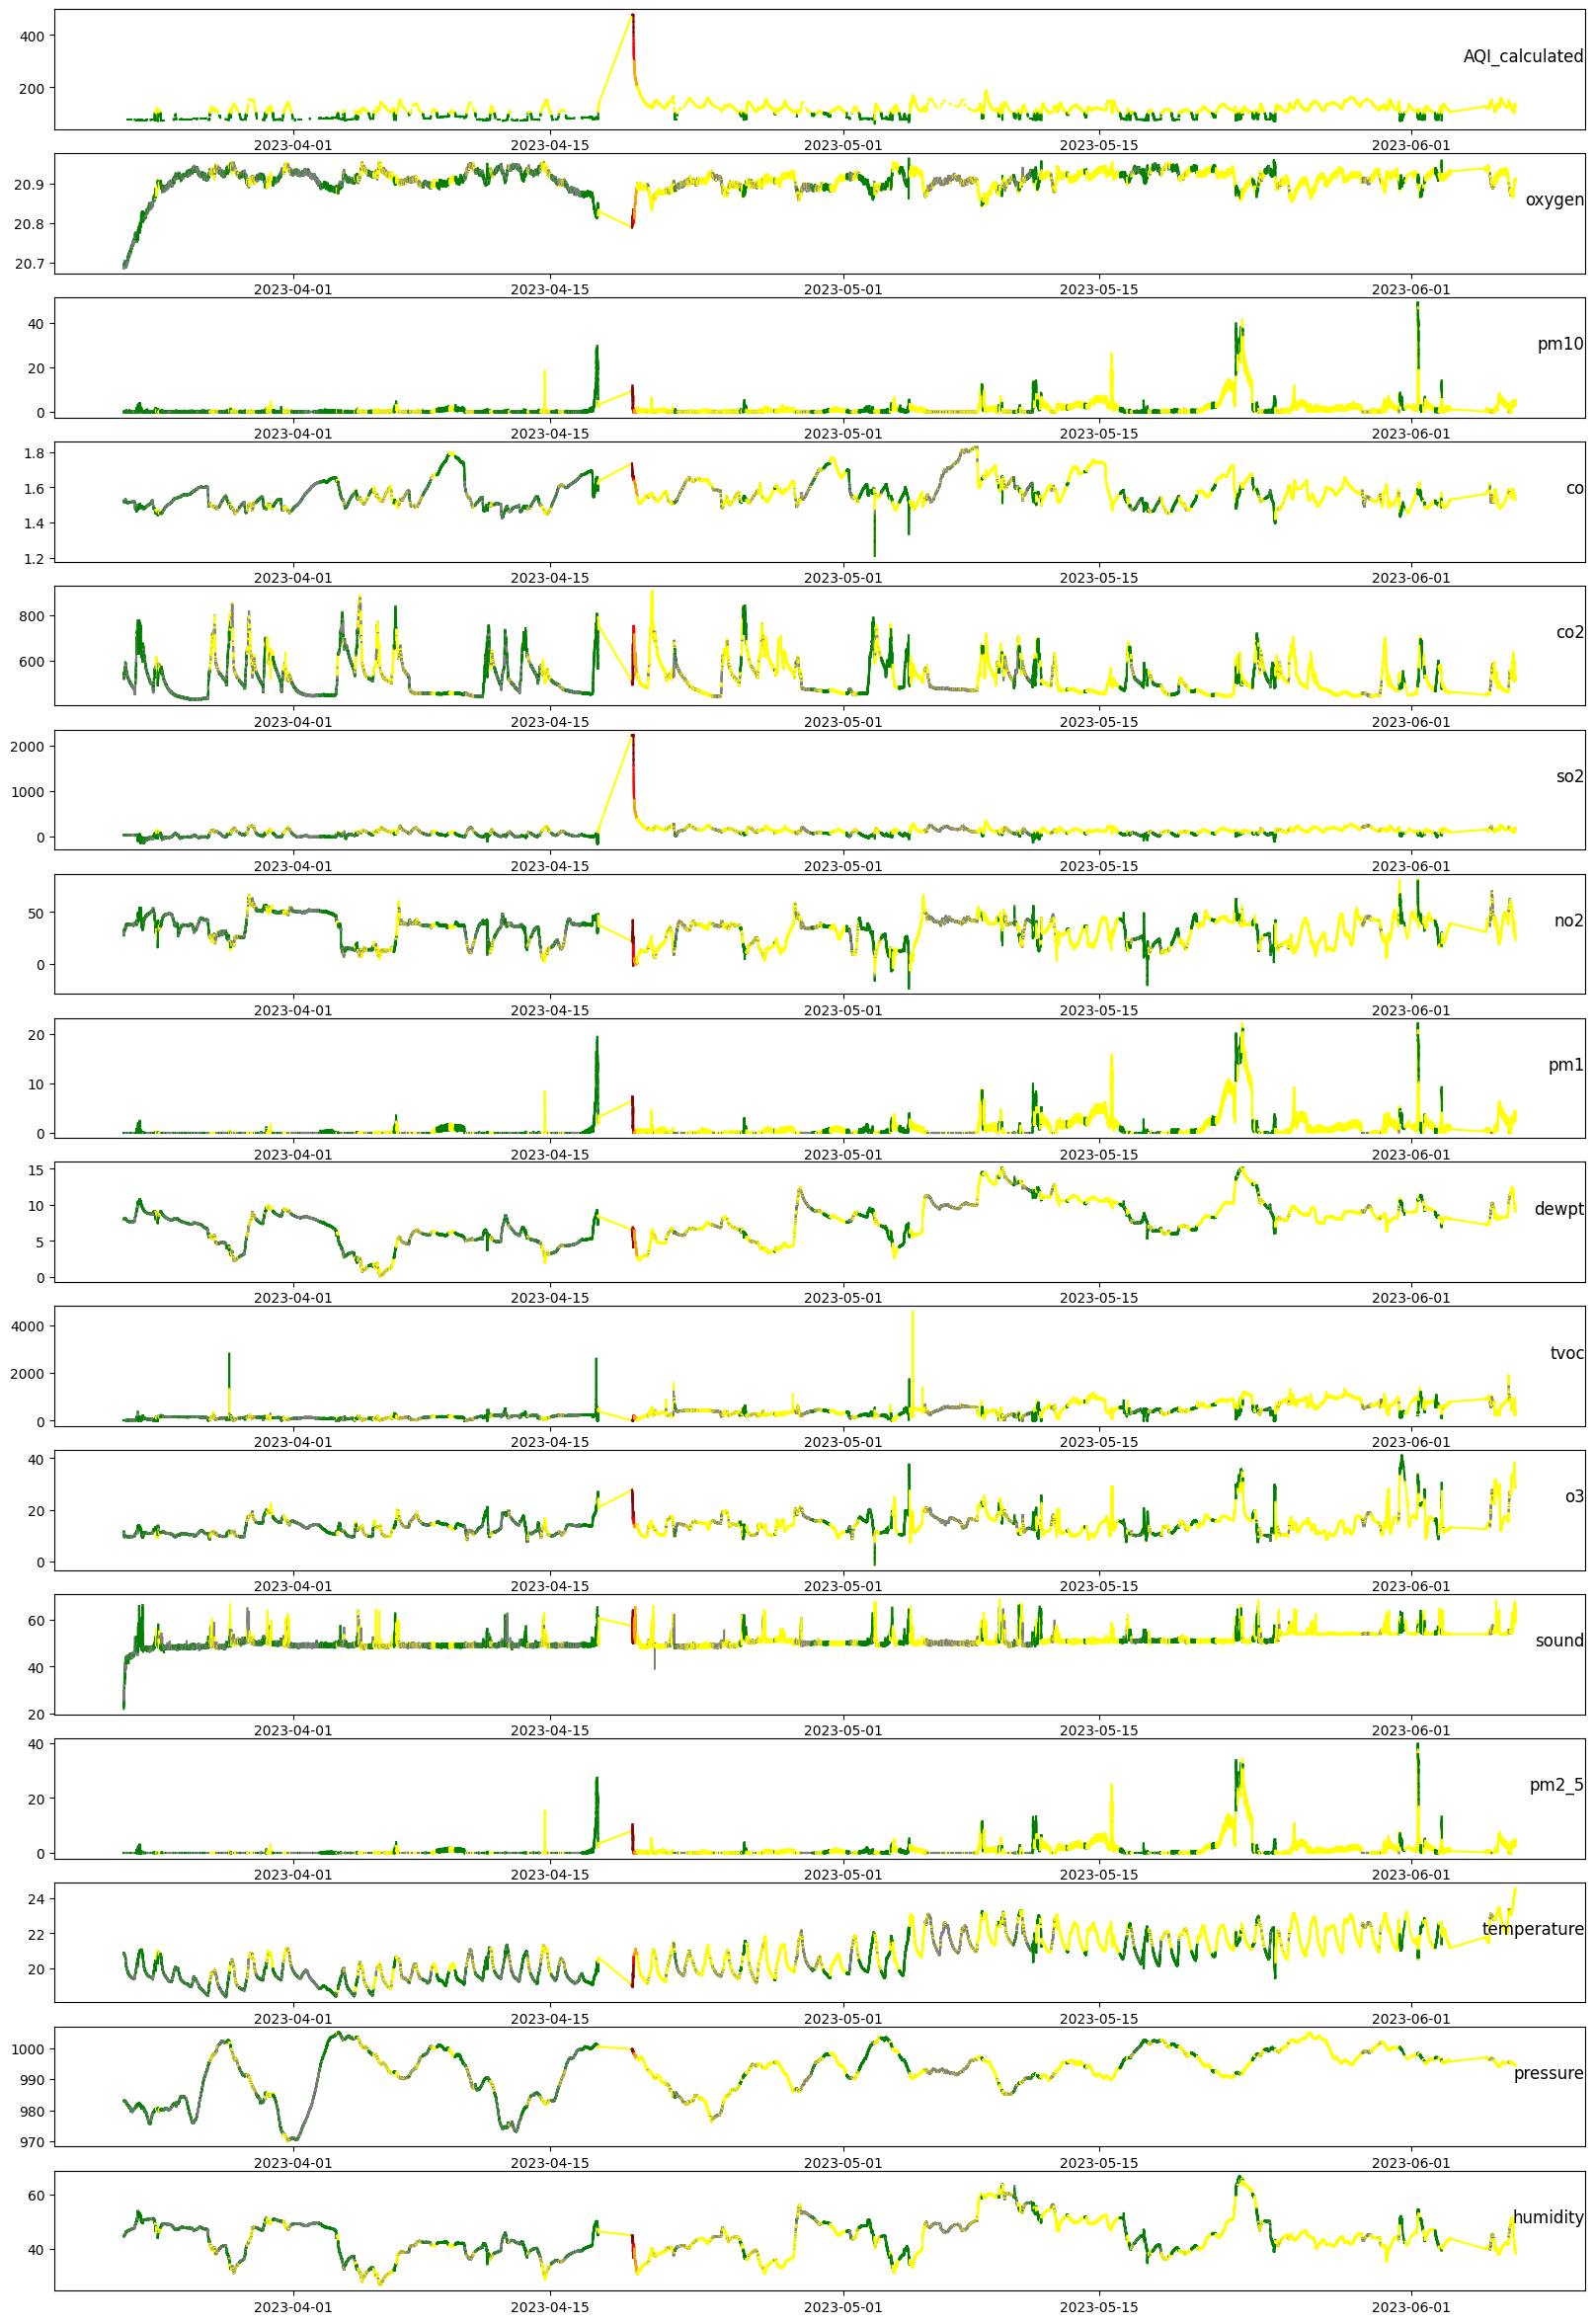

In [24]:
# Define the color mapping for AQI buckets
def get_aqi_color(aqi):
    if aqi <= 50:
        return 'lightgreen'
    elif aqi <= 100:
        return 'green'
    elif aqi <= 200:
        return 'yellow'
    elif aqi <= 300:
        return 'orange'
    elif aqi <= 400:
        return 'red'
    elif aqi > 400:
        return 'darkred'  #Good  Satisfactory  Moderate  Poor  Very Poor  Severe
    else:
        return 'gray'  # For NaN or undefined AQI

# Apply the color mapping to AQI_calculated column
data['AQI_color'] = data['AQI_calculated'].apply(get_aqi_color)

values = data.drop(columns=['AQI_color']).values
dates = data.index
groups = list(range(data.shape[1] - 1)) 
i = 1

plt.figure(figsize=(20, 30))
for group in groups:
    col_name = data.columns[group]
    plt.subplot(len(groups), 1, i)

    colors = data['AQI_color'].values
    for j in range(len(dates) - 1):
        plt.plot(dates[j:j+2], values[j:j+2, group], color=colors[j])
    plt.title(col_name, y=0.5, loc='right')
    i += 1
plt.show()
